# Introduction

Currently, one of the most common (and accurate) methods for conducting a Blood
Smear is manually. The goal of this project is to develop a neural network that can classify WBCs from images as part of an eventual effort to automate the procedure without a significant loss in accuracy. By automating this process, we can not only speed it up, but we also reduce the amount of human labor required to conduct a test, thus lowering the overall cost.

The dataset for this project is a collection of ~12,500 images that are 240 x 320. The images contain several RBCs and a single, highlighted WBC. Each WBC falls into one of four categories: Eosinophil, Lymphocyte, Monocyte, or Neutrophil. The dataset can be found on Kaggle [here](https://www.kaggle.com/paultimothymooney/blood-cells). Through accurate classification, accurate proportions of each WBC type could be calculated and checked for normalcy. Additionally, cell images could be further inspected for abnormalities.

# Module Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
%matplotlib inline
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import keras

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

Using TensorFlow backend.


# Data Exploration

We begin by collecting, processing, and organizing our data from the directory.

In [2]:
def fetch_data(directory, classes, im_size):
    # initialize return variables
    X_train, y_train, X_test, y_test = [],[],[],[]
    wbc_df = pd.DataFrame(columns=['file_name', 'type', 'group'])
    
    # iterate through each of our classes
    for i, wbc_type in enumerate(classes):
        path = directory + 'TRAIN/' + wbc_type + '/'
        files = os.listdir(path)
        print("Fetching {} Image Files".format(wbc_type.title()))
        # this pause prevents tqdm progress bars from bugging
        # time.sleep(0.25)
        for file in tqdm(files):
            image = plt.imread(path + file)
            # resize and rescale image arrays
            im_arr = np.array(Image.fromarray(image).resize(size))
            im_arr = im_arr / 255.
            X_train.append(im_arr)
            y_train.append(i+1)
            
            new_row = {'file_name': file,
                       'type': wbc_type, 
                       'group': 'TRAIN'}
            wbc_df = wbc_df.append(new_row, ignore_index=True)
            
        path = directory + 'TEST/' + wbc_type + '/'
        files = os.listdir(path)
        for file in tqdm(files):
            image = plt.imread(path + file)
            im_arr = np.array(Image.fromarray(image).resize(size))
            im_arr = im_arr / 255.
            X_test.append(im_arr)
            y_test.append(i+1)
            
            new_row = {'file_name': file,
                       'type': wbc_type,
                       'group': 'TEST'}
            wbc_df = wbc_df.append(new_row, ignore_index=True)
            
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    # When converting labels to one-hot vectors we need to include an extra class.
    # Without this extra class, the model refuses to learn, but I'm not clear yet on why.
    y_train = to_categorical(y_train, len(classes)+1)
    y_test = to_categorical(y_test, len(classes)+1)
    
    return X_train, y_train, X_test, y_test, wbc_df

In [ ]:
directory = 'dataset2-master/images/'
wbc_types = ['EOSINOPHIL', 'NEUTROPHIL', 'LYMPHOCYTE', 'MONOCYTE']
img_rows, img_cols = 90, 120
size = (img_cols, img_rows)

X_train, y_train, X_test, y_test, wbc_df = fetch_data(directory, wbc_types, size)

  0%|                                                 | 0/2497 [00:00<?, ?it/s]

Fetching Eosinophil Image Files


  0%|                                         | 6/2499 [00:00<00:49, 49.99it/s]

Fetching Neutrophil Image Files


  0%|                                         | 2/2483 [00:00<02:04, 20.00it/s]

Fetching Lymphocyte Image Files


 40%|████████████████                        | 249/620 [00:05<00:07, 46.62it/s]

Let's take a look at an example of each blood cell type.

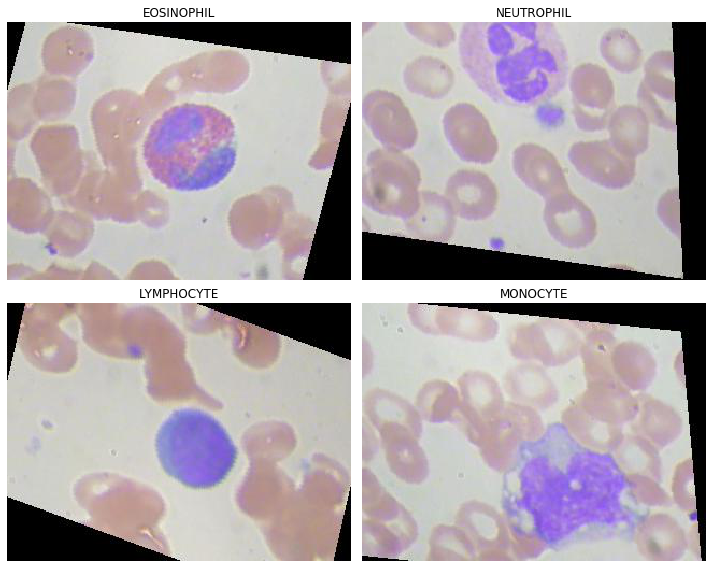

In [4]:
plt.figure(figsize=(10,8))

for i, wbc_type in enumerate(wbc_types):
    row = wbc_df[wbc_df['type'] == wbc_type].iloc[0]
    file = row.file_name
    group = row.group
    path = directory + group + '/' + wbc_type + '/' + file
    image = plt.imread(path)
    plt.subplot(2,2,i+1)
    plt.title(wbc_type)
    plt.axis('off')
    plt.imshow(image)

plt.tight_layout()
plt.show()

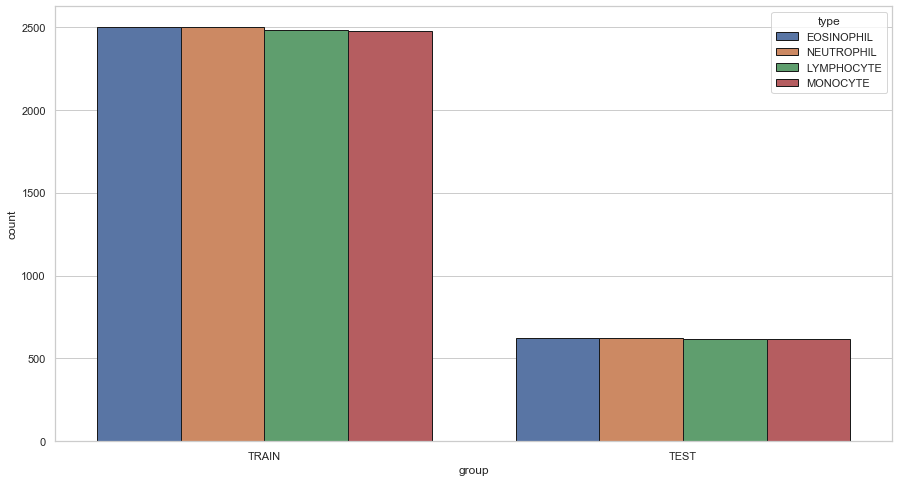

In [45]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
sns.countplot(x='group', hue='type', data=wbc_df, ec='k')
plt.show()

The images show that each of the four cell types are quite easily visually differentiable. Additionally, we can see from the countplot that our training data is very well balanced with ~2,500 images of each WBC cell type. The same goes for our testing data which contains ~625 images from each type.

Due to the balance in our dataset, we don't need to worry about doing any resampling for this classification task. Additionally, accuracy is a perfectly acceptable metric for model evaluation.

# Model Construction

Since the input to be classified are image files, I will be using a Convolutional Neural Network for these purposes. Due to limitations on available computing power, I'll build a relatively small network with the architecture shown below. The model takes a little from the AlexNet architecture and a little from the VGG-16 architecture (primarily the smaller filters, and design of individual convolution layers). I tried training more complex models, but this architecture yielded roughly the same accuracy as those models with a fraction of the training time. I incorporated dropout in each fully connected layer in order to reduce over-fitting.

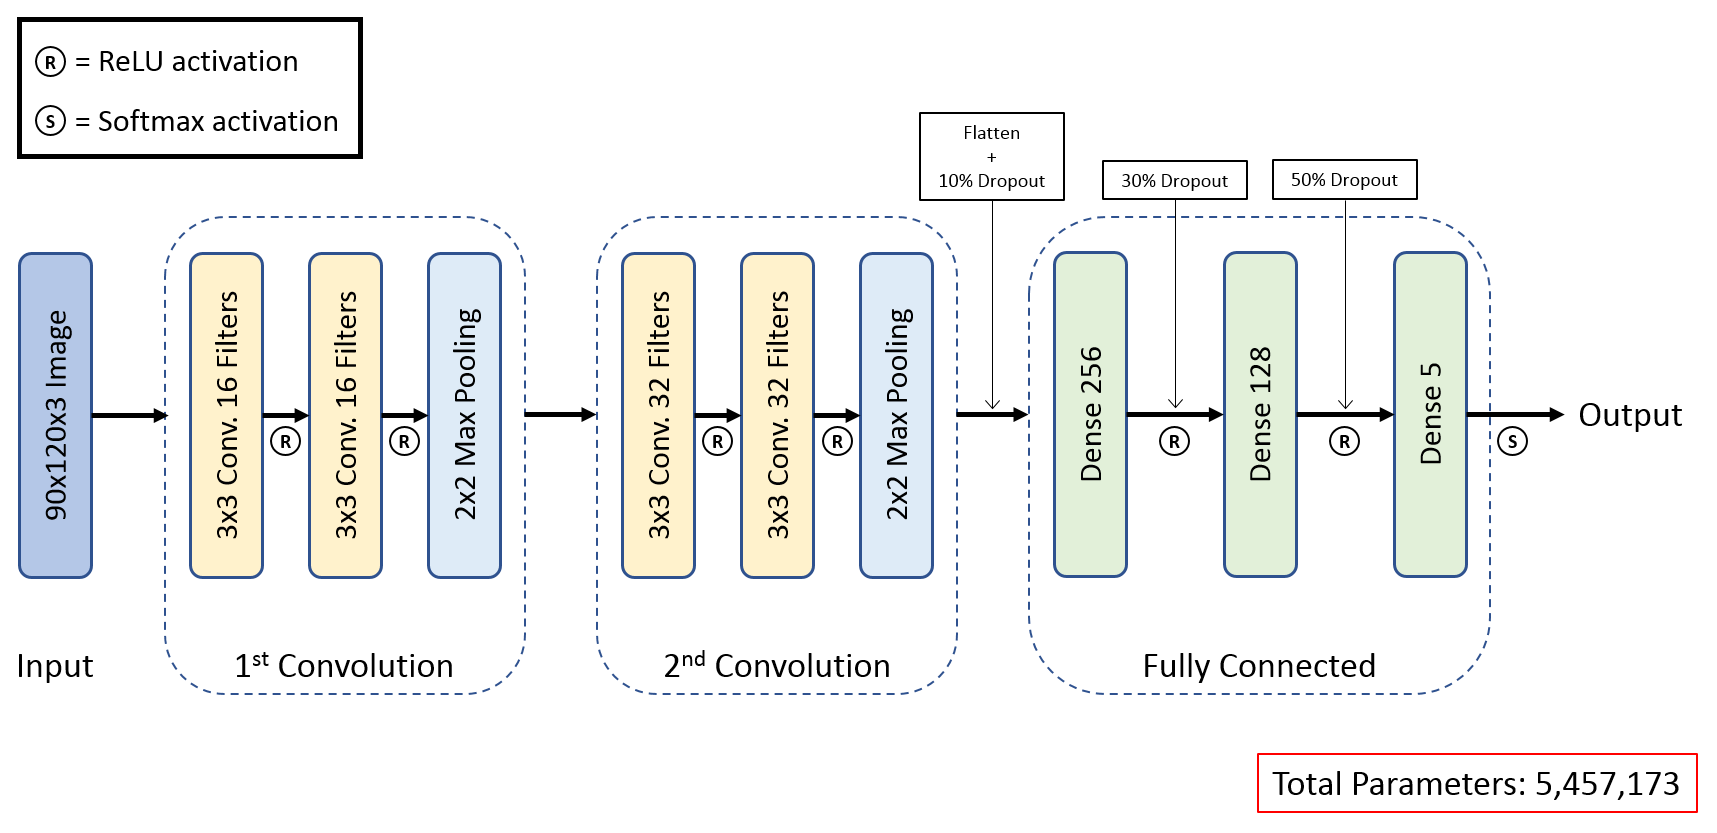

In [6]:
input_shape = (img_rows, img_cols, 3)

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape, strides=1))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(y_train[0]), activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 90, 120, 16)       448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 120, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 60, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 60, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 30, 32)       

# Data Augmentation

The training data will be augmented, also to reduce overfitting. Since we're dealing with white blood cells, which are roughly circular, we augment using random rotation as well as horizontal and vertical flipping. Lastly, we randomly zoom in/out on the images by 20%.

The testing data is not augmented.

In [8]:
trdata = ImageDataGenerator(
    rotation_range = 90,  # randomly rotate images in the range (degrees, 0 to 90)
    horizontal_flip = True,  # randomly flip images horizontally
    vertical_flip = True,  # randomly flip images vertically
    zoom_range = [0.8,1.2]) # randomly zoom images in/out by 20%

tsdata = ImageDataGenerator()

# Checkpointing & Early Stop

I employed checkpointing to ensure that the captured model weights correspond to the optimal performance (measured by accuracy) on the testing data. Early stopping allowed me to utilize a (relatively) large number of training epochs without worrying too much about wasted training time. The model will stop itself if 20 epochs pass without any increase in test accuracy.

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("newest_model.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=20,
                      verbose=1,
                      mode='auto')

hist = model.fit_generator(trdata.flow(X_train, y_train, batch_size=32),
                           steps_per_epoch=len(X_train) / 32,
                           epochs=100,
                           validation_data = tsdata.flow(X_test, y_test, batch_size=32),
                           callbacks=[checkpoint, early])


Epoch 1/100
312/311 [==============================] - 149s 477ms/step - loss: 1.4163 - accuracy: 0.2627 - val_loss: 1.3548 - val_accuracy: 0.3981

Epoch 00001: val_accuracy improved from -inf to 0.39807, saving model to newest_model.h5
Epoch 2/100
312/311 [==============================] - 149s 478ms/step - loss: 1.3142 - accuracy: 0.3683 - val_loss: 1.1722 - val_accuracy: 0.5239

Epoch 00002: val_accuracy improved from 0.39807 to 0.52392, saving model to newest_model.h5
Epoch 3/100
312/311 [==============================] - 149s 479ms/step - loss: 1.1998 - accuracy: 0.4442 - val_loss: 0.8806 - val_accuracy: 0.5955

Epoch 00003: val_accuracy improved from 0.52392 to 0.59550, saving model to newest_model.h5
Epoch 4/100
312/311 [==============================] - 148s 474ms/step - loss: 1.0580 - accuracy: 0.5300 - val_loss: 0.8588 - val_accuracy: 0.6647

Epoch 00004: val_accuracy improved from 0.59550 to 0.66466, saving model to newest_model.h5
Epoch 5/100
312/311 [=====================

# Accuracy & Loss Plots

In [14]:
def plot_learning_curve(history):
    plt.figure(figsize=(14,8))
    
    # plot training and test accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    
    # plot training and test loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

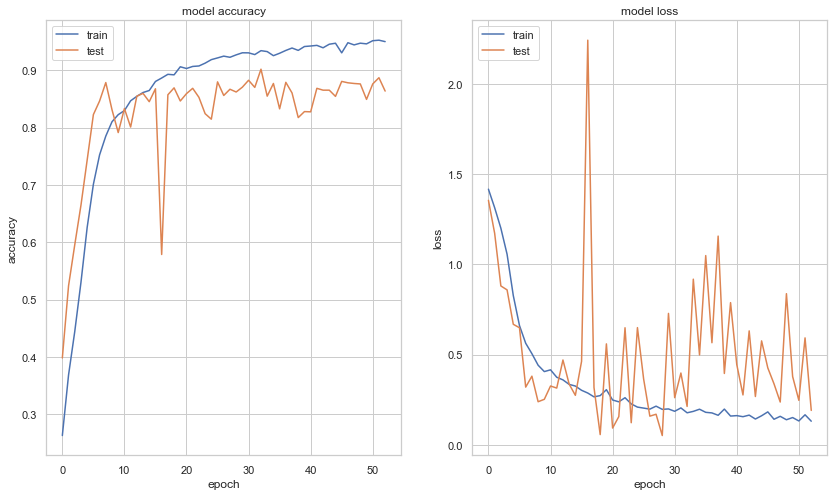

In [15]:
plot_learning_curve(hist)

# Model Evaluation

I import the best model I managed to train, use it to predict labels on all of the test data, and then plot a confusion matrix.

In [52]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    from sklearn.metrics import recall_score

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    recall = cm[0][0] / np.sum(cm, axis=0)[0]
    dummy_acc = np.sum(cm, axis=0).max() / float(np.sum(cm))

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True WBC Type')
    plt.xlabel('Predicted WBC Type\n\naccuracy={:0.4f}'.format(accuracy))
    plt.show()

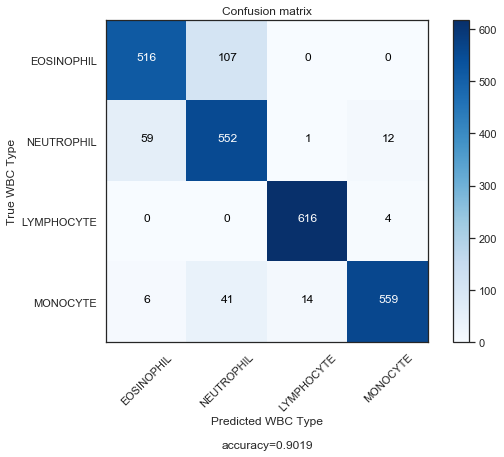

In [53]:
best_model = load_model('best_model.h5')

y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

sns.set(style="white")
plot_confusion_matrix(cm, wbc_types, cmap='Blues', normalize=False)

The best model I was able to train with this relatively small CNN has 90% accuracy on the test data. Considering the test data is more or less perfectly balanced, this is substantially better than the expected dummy accuracy of 25%. This is pretty good for a simple model that trains rather quickly. 

# Next Steps

There are several ideas worth exploring to increase the accuracy of this White Blood Cell classifier.

1. **Bigger Model**: Adding more convolutional layers to the model should, in theory, increase the accuracy. If I had access to more computing power, I would try something much closer to the VGG-16 model, which is substantially more complex than this model. For comparison, my model has about 5.5 million parameters to optimize whereas the VGG-16 model has 138 million (~25x as many).

2. **Multiple Models**: It looks like the model does a much better job differentiating Lymphocytes and Monocytes than it does with the Granulocytes (Eosinophils and Neutrophils). It might be worth exploring a model that classifies either Granulocytes or non-Granuloctyes, and then using the classified output of this model as inputs into two separate models: one that differentiates between Eosinophils and Neutrophils, and another that differentiates between Lymphocytes and Monocytes.

3. **Preprocessing**: The image files that are being used to train the model are not ideal, in that they contain a lot of non-WBC pixels. The model would potentially train better if the images were adjusted to feature the white blood cells centered, and taking up the majority of the image.

# Conclusion

This model does a good job, but 90% accuracy is definitely lower than what you'd expect from a lab technician. This model has the advantage of speed, meaning it could produce white blood cell levels based on significantly more data than a lab tech is reasonably capable of looking through. If I can get this model closer to 97-98% accuracy, then we're looking at something worth deploying in a lab setting. A model like that would significantly speed up the turnaround on test results, and free up lab technicians to focus on other tasks.